In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from rational_functions import fit_polynomial, fit_rational_func
from gauss_freud_quad import get_nodes_and_weights
from scipy.optimize import brentq

import mgo

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

### Dispersion Relation

In [3]:
plot_name = 'linear_T'

In [4]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 34.8e9
omega0 = 2*np.pi*f0
x0 = 0

# Constants
n0 = 2.07e19
T0 = 38.5*e
L_ne = 2.8434e-2
L_Te = 0.7295*L_ne
B0 = 0.511

sc_x = 1
sc_k = 1
sc_omega = 1

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    # return T0
    return T0*(1 - x/L_Te)

@torch_func
def n_e(x: ('scalar')):
    return n0*(1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return torch.exp(-lamb(x, k)) * torch.trapezoid(torch.sin(_psi*Omega(x, omega))*torch.sin(_psi)*torch.exp(-lamb(x, k)*torch.cos(_psi)), _psi)

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return (1
     + (omega_p_squared(x)/(omega_c(x)**2)) / (torch.sin(torch.pi * Omega(x, omega)))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _x = sc_x * x
    _k = sc_k * k
    _omega = sc_omega * omega
    return (c/_omega)**2 * (K1(_x, _k, _omega) * (torch.abs(_k)**2) - (_omega/c)**2 * (Stix_S(_x, _omega)**2 - Stix_D(_x, _omega)**2))

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [5]:
k0 = 10e3 / sc_k
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 1 / sc_x

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0),
)

B tensor(0.5110) 
 omega_c tensor(8.9876e+10) 
 n_e tensor(-7.0730e+20) 
 omega_p_squared tensor(-2.2510e+24) 
 Stix_S tensor(57.6540) 
 Stix_D tensor(-23.2870) 
 lambd tensor(-3.9576) 
 v_Te_squared tensor(-6.3936e+14) 
 K1_int tensor(479.5933) 
 K1 tensor(-136676.3125) 
 D tensor(-25695878.)


#### Plot Dispersion in $(k, f)$ space

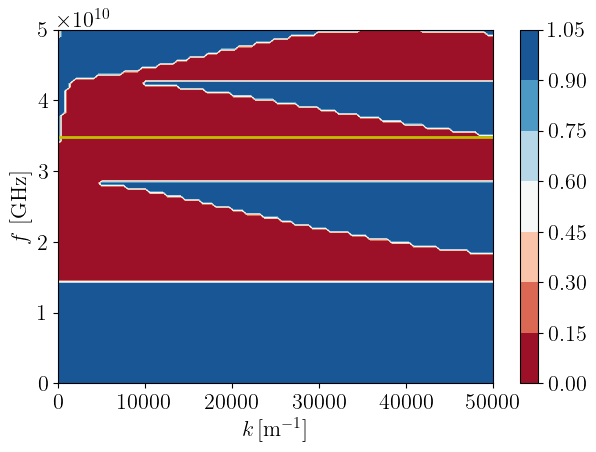

In [6]:
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 0 / sc_x

ki = np.linspace(0, 50000, 100) / sc_k
omegai = 2*np.pi*np.linspace(1e-6, 50e9, 100) / sc_omega
K, O = np.meshgrid(ki, omegai, indexing='ij')
D_vec = np.vectorize(D)

plt.contourf(K * sc_k, O/(2*np.pi) * sc_omega, D_vec(np.zeros_like(K), K, O) > 0, cmap='RdBu')
plt.plot(plt.gca().get_xlim(), [f0 * sc_omega, f0 * sc_omega], 'y-', linewidth=2)
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, [\mathrm{m^{-1}}]$')
plt.colorbar()
plt.tight_layout()
plt.savefig('./plots/MGO_warm_dispersion_' + plot_name + '.pdf')
plt.savefig('./plots/MGO_warm_dispersion_' + plot_name + '.png', dpi=600)
plt.show()

#### Find initial $k_0$

In [7]:
k0 = get_k0(x0, omega0, 0, 1000 / sc_k)
k0

159.35710100713789

In [8]:
# k_low = np.linspace(0, 1000 / sc_k, 100)
# plt.plot(k_low * sc_k, D(x0, k_low, omega0))
# plt.plot(k0 * sc_k, 0, 'ro')
# plt.grid()
# plt.show()

### Ray Tracing

In [9]:
sc_x, sc_k, sc_omega

(1, 1, 1)

In [10]:
ND = 1
nt = 4000
xs = np.zeros((nt, ND))
ks = np.zeros((nt, ND))

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0 = x0, k0=k0, omega0=omega0, tmin=0, tmax=40e-9*sc_omega, D=D, x_min=x0, tsteps=nt, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
sol_nt = len(sol.t)
xs[:sol_nt, :] = sol.y[:ND].T
ks[:sol_nt, :] = sol.y[ND:].T
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt, :]
ks = ks[:min_nt, :]
zs = np.concatenate([xs, ks], axis=-1)
print(nt)

3612


In [11]:
traced_D = D_vec(xs, ks, omega0*np.ones_like(xs))

In [12]:
# plt.plot(t*1e9, traced_D, label='$D(x(t), k(t), \omega)$')
# plt.ylim(-0.01, 0.01)
# plt.xlabel(r'$t$ [ns]')
# plt.legend()
# plt.grid()

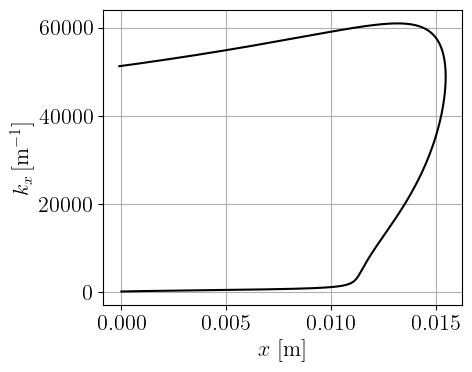

In [13]:
fig = plt.figure(figsize=(5,4))
plt.plot(xs[np.round(traced_D, 2) == 0], ks[np.round(traced_D, 2) == 0], 'k-')
plt.plot(xs[np.round(traced_D, 2) != 0], ks[np.round(traced_D, 2) != 0], 'k--')
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$k_x \, \mathrm{[m^{-1}]}$')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/mgo_1D_warm_dispersion_manifold_' + plot_name + '.png', dpi=600)
plt.savefig('./plots/mgo_1D_warm_dispersion_manifold_' + plot_name + '.pdf')
plt.show()

### Apply MGO

In [14]:
J = fd.grad(xs.squeeze(), t)
i_caust = np.argmin(np.abs(J))
t_save = t[i_caust] + np.array([-10, -2, -1, -0.3, -0.15, -0.1, -0.05, -0.01, 0, 0.01, 0.1, 0.15, 0.3, 1, 2, 10])*1e-9
i_save = [0] + [np.argmin(np.abs(t - t0)) for t0 in t_save] + [nt-1]

In [15]:
# plt.figure(figsize=(10,5))
# plt.plot(xs, ks, 'k-')
# plt.plot(xs[i_caust], ks[i_caust], 'ro')
# plt.grid()
# plt.show()

In [16]:
branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_save=i_save)
results = mgo_info['saved_results']

In [17]:
field = mgo.superpose_ray_fields(phi0=1, x0=0, xs=xs, branch_masks=branch_masks, ray_field=ray_field)

### Inspect Results

In [18]:
xi = np.linspace(np.min(xs), np.max(xs), 10000)

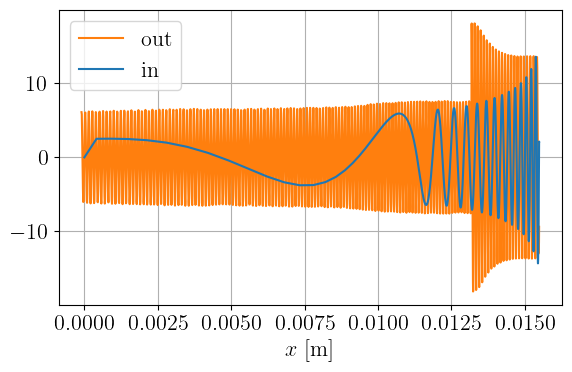

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(xs[branch_masks[1], :], np.real(ray_field[branch_masks[1]]), '-', color='tab:orange', label='out')
plt.plot(xs[branch_masks[0], :], np.real(ray_field[branch_masks[0]]), '-', color='tab:blue', label='in')
plt.legend()
plt.grid()
plt.xlabel(r'$x$ [m]')
plt.tight_layout()
plt.savefig('./plots/MGO_warm_field_in_out_' + plot_name + '.pdf')
plt.savefig('./plots/MGO_warm_field_in_out_' + plot_name + '.png', dpi=600)
plt.show()

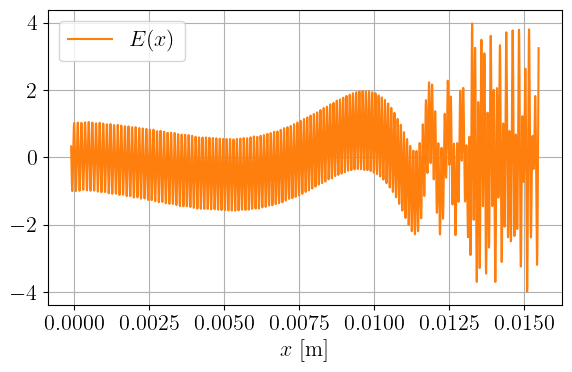

In [20]:
plt.figure(figsize=(6, 4))
N_phases = 1
for i in range(N_phases):
    plt.plot(xi, np.real(np.exp(1j*i*2*np.pi/N_phases)*field(xi)), '-', color='tab:orange', label='$E(x)$')

# plt.plot(xi, np.abs(field(xi)), 'k-', label=r'$|E(x)|$', linewidth=0.5)
# plt.plot(xi, -np.abs(field(xi)), 'k-', label=r'$-|E(x)|$', linewidth=0.5)
plt.xlabel(r'$x$ [$\mathrm{m}$]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./plots/MGO_warm_field_' + plot_name + '.pdf')
plt.savefig('./plots/MGO_warm_field_' + plot_name + '.png', dpi=600)
plt.show()

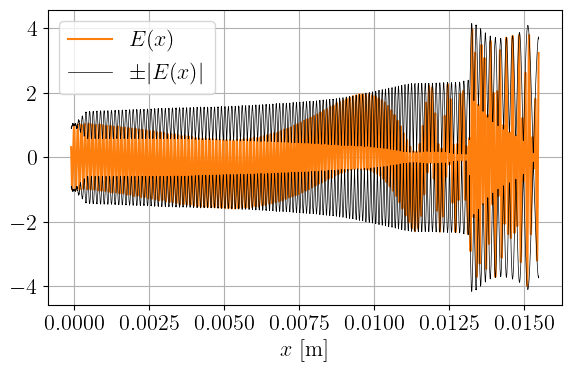

In [23]:
plt.figure(figsize=(6, 4))
N_phases = 1
for i in range(N_phases):
    plt.plot(xi, np.real(np.exp(1j*i*2*np.pi/N_phases)*field(xi)), '-', color='tab:orange', label=r'$E(x)$')

plt.plot(xi, np.abs(field(xi)), 'k-', label=r'$\pm |E(x)|$', linewidth=0.5)
plt.plot(xi, -np.abs(field(xi)), 'k-', linewidth=0.5)
plt.xlabel(r'$x$ [$\mathrm{m}$]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./plots/MGO_warm_field_with_envelope_' + plot_name + '.pdf')
plt.savefig('./plots/MGO_warm_field_with_envelope_' + plot_name + '.png', dpi=600)
plt.show()

#### Prefactor

In [ ]:
Nt = mgo_info['Nt']
Upsilon = mgo_info['Upsilon']

In [ ]:
# plt.plot(xs[branch_masks[1]], Nt[branch_masks[1]], color='tab:orange')
# plt.plot(xs[branch_masks[0]], Nt[branch_masks[0]], color='tab:blue')
# # plt.xlim(12.5e-3,13.5e-3)
# plt.grid()

In [ ]:
# plt.plot(xs[branch_masks[1]], Upsilon[branch_masks[1]], color='tab:orange')
# plt.plot(xs[branch_masks[0]], Upsilon[branch_masks[0]], color='tab:blue')
# plt.plot(xs, np.abs(Upsilon), color='tab:red')
# # plt.xlim(12.5e-3,13.5e-3)
# plt.grid()

### Analytic Continuation

In [ ]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

In [ ]:
# epsmax = np.round(np.mean([1/np.emath.sqrt(results[0]['s_m'][0]), 1/np.emath.sqrt(results[0]['s_p'][0])]), -3)
# eps_R = np.linspace(-5*epsmax,5*epsmax, 1000)
# eps_I = np.linspace(-5*epsmax,5*epsmax, 1000)
# Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
# Eps = Eps_R + 1j*Eps_I
# l_j, _ = get_nodes_and_weights(n=10)
# l_j = l_j.astype(np.complex_)

# ncols, nrows = 7, 3
# fig = plt.figure(1, figsize=(ncols*3,nrows*2))
# fig2 = plt.figure(2, figsize=(ncols*3.5,nrows*3))
# fig3 = plt.figure(3, figsize=(ncols*3.5,nrows*3))
# fig4 = plt.figure(4, figsize=(ncols*3.5,nrows*3))
# fig5 = plt.figure(5, figsize=(ncols*3.5,nrows*3))

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     k = ks[it, 0]
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, f_t1, 'k-')
#     ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
#     ax.set_title(r'$f(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig2.add_subplot(nrows, ncols, 1 + i)
#     ax.axis('equal')
#     t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m = (result[key] for key in ['t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m'])
#     eps_rho = eps_rho.squeeze()
#     contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title(r'$f(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

#     # Plot node points along integral path
#     ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
#     ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
# fig2.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig3.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, Phi_t1, 'k-')
#     ax.plot(eps_rho, g_fit(eps_rho), '--', color='tab:orange')
#     ax.set_title(r'$\Phi(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig3.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig4.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, fd.grad(f_t1, eps_rho), 'k-')
#     ax.plot(eps_rho, f_fit.deriv(axis=0, order=1)(eps_rho), '--', color='tab:orange')
#     ax.set_title(r"$f'(t = " + str(np.round((t1 - t[i_caust])*1e9,2)) + r"$ ns$, \epsilon)$")
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig4.tight_layout()


# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig5.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, Theta_t1, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     k = ks[it, 0]
#     ax.plot(eps_rho, Theta_t1, 'k-')
#     ax.set_title(r'$\Theta(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + r'$ ns$, \epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig5.tight_layout()

# plt.show()